# Testing DNABERT embedding 

Here we will test if we can use the pre-trained DNABERT model to map DNA barcodes to a "valid metric space". Mainly, we want to contrast the results of 1-kNN accuracy with the 1D-CNN architecture, and stablish a baseline for later when we train our model from scratch. To my understaning, these are the parameters of the model:

* Sequence Length: 512
* Backbone: BERT_small
* Proportion of the input masked: 15%
* Hidden Layer Size: 768

## Preparing the data

In [1]:
import numpy as np
import pandas as pd
import random


#Read dataset file
dataset = pd.read_csv('../barcode_insect_database.tsv',sep='\t')

# Start filetring to get high quality Unseen sequences
# In particular: Sequences from known species with more than 50 individuals per species.
filtered = dataset[dataset['species_name'].notna()]
s = filtered.groupby('species_name').sampleid.count()
l = s[s > 50].index.to_list()

#Sample 100 species at random to be unseen by our model for generalization.
selected_species = random.sample(l, k=100)

print(len(set(selected_species)))
unseen = filtered[filtered['species_name'].isin(selected_species)]
train = pd.concat([dataset, unseen, unseen]).drop_duplicates(keep=False)



100


In [2]:
from utils import seq2kmer

#Ideally we would sample at most 10 sequences per sequence to reduce computational cost
#without worrying for 'N's or '_'s

#For now we need to restirct to sequences without gaps and '-'
test = unseen[unseen['nucleotides'].apply(lambda x: x.count('-') ==0)
                & unseen['nucleotides'].apply(lambda x: x.count('N') == 0)]

#test = unseen.groupby('species_name').apply(lambda x: x.sample(10)).reset_index(drop=True)


tokenized_test = []
# Aply tokenization to sequences and save them to the dev file
c = 0
for i, row in test.iterrows():
    barcode = row["nucleotides"].strip()
    tokenized_barcode = seq2kmer(barcode, 6)
    tokenized_test.append([tokenized_barcode, random.randint(0,1)])  #I am including a fake label
    c += 1
    if c == 1000:
        break
    
tokenized_test = pd.DataFrame(tokenized_test, columns=["sequence", "label"])
tokenized_test.to_csv("sample_data/ft/6/dev.tsv", sep='\t', index=False)

/localscratch/pmillana.35030010.0/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Testing DNABERT out-of-the-box

In [3]:
#Loading the libraries
import sys
sys.path.append('/home/pmillana/projects/def-khill22/pmillana/DNABERT/src')   #This is where I installed my transformers library

from utils import predict, set_seed
import json


import json
import logging

import torch

from transformers import glue_compute_metrics as compute_metrics
from transformers import glue_convert_examples_to_features as convert_examples_to_features
from transformers import glue_output_modes as output_modes
from transformers import glue_processors as processors


from transformers import (
    WEIGHTS_NAME,
    AdamW,
    AlbertConfig,
    AlbertForSequenceClassification,
    AlbertTokenizer,
    BertConfig,
    BertForSequenceClassification,
    BertForLongSequenceClassification,
    BertForLongSequenceClassificationCat,
    BertTokenizer,
    DNATokenizer,
    DistilBertConfig,
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    FlaubertConfig,
    FlaubertForSequenceClassification,
    FlaubertTokenizer,
    RobertaConfig,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    XLMConfig,
    XLMForSequenceClassification,
    XLMRobertaConfig,
    XLMRobertaForSequenceClassification,
    XLMRobertaTokenizer,
    XLMTokenizer,
    XLNetConfig,
    XLNetForSequenceClassification,
    XLNetTokenizer,
    get_linear_schedule_with_warmup,
)

ALL_MODELS = sum(
    (
        tuple(conf.pretrained_config_archive_map.keys())
        for conf in (
            BertConfig,
            XLNetConfig,
            XLMConfig,
            RobertaConfig,
            DistilBertConfig,
            AlbertConfig,
            XLMRobertaConfig,
            FlaubertConfig,
        )
    ),
    (),
)

MODEL_CLASSES = {
    "dna": (BertConfig, BertForSequenceClassification, DNATokenizer),
    "dnalong": (BertConfig, BertForLongSequenceClassification, DNATokenizer),
    "dnalongcat": (BertConfig, BertForLongSequenceClassificationCat, DNATokenizer),
    "bert": (BertConfig, BertForSequenceClassification, BertTokenizer),
    "xlnet": (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    "xlm": (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    "roberta": (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer),
    "distilbert": (DistilBertConfig, DistilBertForSequenceClassification, DistilBertTokenizer),
    "albert": (AlbertConfig, AlbertForSequenceClassification, AlbertTokenizer),
    "xlmroberta": (XLMRobertaConfig, XLMRobertaForSequenceClassification, XLMRobertaTokenizer),
    "flaubert": (FlaubertConfig, FlaubertForSequenceClassification, FlaubertTokenizer),
}
                    
TOKEN_ID_GROUP = ["bert", "dnalong", "dnalongcat", "xlnet", "albert"] 

### Loading config file 

In [4]:
# Definition of argument class
class get_args:
    def __init__(self, **parameters):
        self.__dict__.update(parameters)
                 
#Load .json file with arguments
with open('predict_config.json') as f:
    config_args = json.load(f)

#print(config_args)
args = get_args(**config_args)

In [5]:
 # Setup CUDA, GPU & distributed training
if args.local_rank == -1 or args.no_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
    args.n_gpu = torch.cuda.device_count()
else:  # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.cuda.set_device(args.local_rank)
    device = torch.device("cuda", args.local_rank)
    torch.distributed.init_process_group(backend="nccl")
    args.n_gpu = 1
args.device = device

print(
    "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s" %(
    args.local_rank,
    device,
    args.n_gpu,
    bool(args.local_rank != -1),
    args.fp16)
)

# Set seed
set_seed(args)

# Prepare GLUE task
args.task_name = args.task_name.lower()
if args.task_name not in processors:
    raise ValueError("Task not found: %s" % (args.task_name))
processor = processors[args.task_name]()
args.output_mode = output_modes[args.task_name]
label_list = processor.get_labels()
num_labels = len(label_list)

# Load pretrained model and tokenizer
if args.local_rank not in [-1, 0]:
    torch.distributed.barrier()  # Make sure only the first process in distributed training will download model & vocab

args.model_type = args.model_type.lower()
config_class, model_class, tokenizer_class = MODEL_CLASSES[args.model_type]

if not args.do_visualize and not args.do_ensemble_pred:
    config = config_class.from_pretrained(
        args.config_name if args.config_name else args.model_name_or_path,
        num_labels=num_labels,
        finetuning_task=args.task_name,
        cache_dir=args.cache_dir if args.cache_dir else None,
    )

    config.hidden_dropout_prob = args.hidden_dropout_prob
    config.attention_probs_dropout_prob = args.attention_probs_dropout_prob
    if args.model_type in ["dnalong", "dnalongcat"]:
        assert args.max_seq_length % 512 == 0
    config.split = int(args.max_seq_length/512)
    config.rnn = args.rnn
    config.num_rnn_layer = args.num_rnn_layer
    config.rnn_dropout = args.rnn_dropout
    config.rnn_hidden = args.rnn_hidden

    tokenizer = tokenizer_class.from_pretrained(
        args.tokenizer_name if args.tokenizer_name else args.model_name_or_path,
        do_lower_case=args.do_lower_case,
        cache_dir=args.cache_dir if args.cache_dir else None,
    )
    model = model_class.from_pretrained(
        args.model_name_or_path,
        from_tf=bool(".ckpt" in args.model_name_or_path),
        config=config,
        cache_dir=args.cache_dir if args.cache_dir else None,
    )
    print('finish loading model')

    if args.local_rank == 0:
        torch.distributed.barrier()  # Make sure only the first process in distributed training will download model & vocab

    model.to(args.device)

    print("Training/evaluation parameters %s" %(args))


# Prediction
predictions = {}
if args.do_predict and args.local_rank in [-1, 0]:
    tokenizer = tokenizer_class.from_pretrained(args.output_dir, do_lower_case=args.do_lower_case)
    checkpoint = args.output_dir
    print("Predict using the following checkpoint: %s", checkpoint)
    prefix = ''
    model = model_class.from_pretrained(checkpoint)
    model.to(args.device)
    prediction = predict(args, model, tokenizer, prefix=prefix)

Process rank: -1, device: cpu, n_gpu: 1, distributed training: False, 16-bits training: True
<class 'transformers.tokenization_dna.DNATokenizer'>
Predict using the following checkpoint: %s /home/pmillana/projects/def-khill22/pmillana/DNABERT/examples/ft/6
finish loading examples
number of processes for converting feature: 10
1 processor started !
2 processor started !
3 processor started !
4 processor started !
5 processor started !
6 processor started !
7 processor started !
8 processor started !
9 processor started !
10 processor started !


Predicting: 100%|██████████| 125/125 [06:07<00:00,  2.94s/it]
/localscratch/pmillana.35030010.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
latent = []
for batch in prediction:
    latent.extend(batch)

latent = np.array(latent)
print(latent.shape)

(1000, 768)


/tmp/ipykernel_33655/3706044600.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(embedding[:, 0],


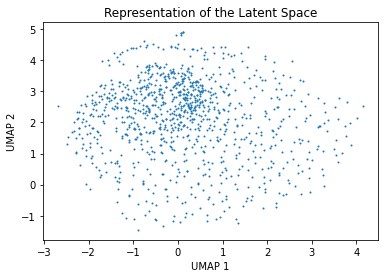

In [7]:
import matplotlib.pyplot as plt 
import umap

embedding = umap.UMAP(random_state=42).fit_transform(latent)
fig, ax = plt.subplots(nrows=1, ncols=1) 
ax.set_title("Representation of the Latent Space")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

ax.scatter(embedding[:, 0],
           embedding[:, 1],
           #c=y_true,
           s=1,
           cmap='Spectral')
plt.show()
fig.savefig(f'learned_representation.jpg', dpi =150)
